In [1]:
! git clone https://github.com/mgh2xx/FinalProject.git

Cloning into 'FinalProject'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 124 (delta 45), reused 98 (delta 26), pack-reused 0 (from 0)
Receiving objects: 100% (124/124), 1.65 MiB | 5.02 MiB/s, done.
Resolving deltas: 100% (45/45), done.


# Exploratory Data Analysis

## Audience/Stakeholders

- Clearly identify who your are writing your final report for

This final report on the performance of UVA men's basketball is intended for the Coaching Staff, as well as the Athletic Department. These stakeholders are involved in studying and making decisions about player developments, training loads, game preparations, and long-term performance strategies.

## Problem Statement

- Create a concise and compelling problem or question that guides your analysis.
  - Ex. "The men's basketball team had a worse performance this year. Did preparation around games change? How did playerload, jumps, high accelerations, and change of direction compare before games over the current season and the previous season?"
  
In today’s college basketball climate where players often jump from school to school, many programs have struggled to adapt. Many programs, like UVA, have historically relied on player development with the convention of players staying at a single school throughout their college career. Given the shifting landscape, we want to analyze whether or not a single season is enough for a player to truly develop and progress. We will look at the Catapult data of several players over the course of a season, tracking how their PlayerLoad/min and jump/acceleration band distributions evolve. We want to measure individual growth with the aim of driving scouting decisions. Should coaches scout players with the anticipation that significant player development can happen over the course of just one season or should they recruit more talented players with less room for growth under the assumption that one season isn’t enough for a player to mature?

## Important Variables

- List which ones are important for your analysis and why.

## Merging and Cleaning the Dataset

- Clean the data: Remove duplicates, handle missing values, correct data types

- Your final dataset should include only variables relevant to your problem

In [36]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Loading in data from season 1 and 2
s1 = pd.read_csv("FinalProject/data/catapult season 1.csv")
s2 = pd.read_csv("FinalProject/data/catapult season 2.csv")

# Adding column with season to each dataset
s1["Season"] = 1
s2["Season"] = 2

# Combining the two seasons of data into a single data frame
data = pd.concat([s1, s2])
# Ignoring the UserWarning raised by the above line. The warning raised tells me that not setting a specific format or handing errors could be problematic, but further
# examination of the Date column showed that is not, so I am hiding the warning from printing
warnings.simplefilter(action = "ignore", category = UserWarning)

# Converting date column to datetime
data["Date"] = pd.to_datetime(data["Date"])

data.head(1)

,Date,About,Position,Period Number,Period,Total Acceleration Efforts,Total Player Load,Player Load Per Minute,IMA Accel Low,IMA Decel Low,...,Session Total Jump,Session Jumps Per Minute,Total CoD Left,Total CoD Right,Total High IMA,Total IMA,IMA/Min,event-uuid,group-uuid,Season
0,2023-03-14,Athlete I,Guard,1,1. Pre Practice,0,87.437,4.1,3,17,...,95.0,1.05,269.0,306.0,89.0,899.0,NaN,c4e1f0fe-b87a-42ca-8f41-b5b0e4cdfab3,c4e1f0fe-b87a-42ca-8f41-b5b0e4cdfab3,1


In [37]:
columns_of_interest = ["Date", "About", "Period", "Player Load Per Minute", "IMA Accel Low", "IMA Accel High", "IMA Jump Count Low Band", "IMA Jump Count Med Band", "IMA Jump Count High Band"]

data = data[columns_of_interest]

games = data[data["Period"].str.contains("Period") == True]
games = games[games["Period"].str.contains("Play") == False]
games = games[games["Period"].str.contains("Auto") == False]
games.loc[games["Period"].str.contains("Period 1"), "Period"] = "Game Half 1"
games.loc[games["Period"].str.contains("Period 2"), "Period"] = "Game Half 2"
games.loc[games["Period"].str.contains("Period 3"), "Period"] = "Overtime"
games.head()

,Date,About,Period,Player Load Per Minute,IMA Accel Low,IMA Accel High,IMA Jump Count Low Band,IMA Jump Count Med Band,IMA Jump Count High Band
273,2023-03-11,Athlete H,Game Half 1,12.8,25,7,12,4,6
274,2023-03-11,Athlete H,Game Half 2,10.2,26,16,16,5,5
276,2023-03-11,Athlete J,Game Half 1,10.7,54,20,19,12,6
277,2023-03-11,Athlete J,Game Half 2,10.9,37,6,21,6,6
279,2023-03-11,Athlete B,Game Half 1,12.6,5,1,6,1,0


In [38]:
scrims = data[data["Period"].str.contains("Scrim")]
scrims = scrims[scrims["Period"].str.contains("Full")]
scrims = scrims[scrims["Period"].str.contains("Seven") == False]
scrims = scrims[scrims["Period"].str.contains("Basket") == False]
scrims["Period"] = "Scrimmage"
scrims.head()

,Date,About,Period,Player Load Per Minute,IMA Accel Low,IMA Accel High,IMA Jump Count Low Band,IMA Jump Count Med Band,IMA Jump Count High Band
11313,2022-11-15,Athlete D,Scrimmage,11.8,5,0,3,2,0
11315,2022-11-15,Athlete D,Scrimmage,0.5,0,0,0,0,0
11331,2022-11-15,Athlete I,Scrimmage,11.5,6,2,1,1,3
11333,2022-11-15,Athlete I,Scrimmage,10.2,8,1,4,1,1
11349,2022-11-15,Athlete L,Scrimmage,12.9,10,4,1,1,0


In [39]:
data = pd.concat([games, scrims], axis = 0)
data.head()

,Date,About,Period,Player Load Per Minute,IMA Accel Low,IMA Accel High,IMA Jump Count Low Band,IMA Jump Count Med Band,IMA Jump Count High Band
273,2023-03-11,Athlete H,Game Half 1,12.8,25,7,12,4,6
274,2023-03-11,Athlete H,Game Half 2,10.2,26,16,16,5,5
276,2023-03-11,Athlete J,Game Half 1,10.7,54,20,19,12,6
277,2023-03-11,Athlete J,Game Half 2,10.9,37,6,21,6,6
279,2023-03-11,Athlete B,Game Half 1,12.6,5,1,6,1,0


## Descriptive Statistics & Distributions

- Provide Summaries of important variables

- Use visualizations to explore distributions

In [40]:
data.describe()

,Date,Player Load Per Minute,IMA Accel Low,IMA Accel High,IMA Jump Count Low Band,IMA Jump Count Med Band,IMA Jump Count High Band
count,1344,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000
mean,2023-07-03 14:24:38.571428608,11.506399,24.525298,6.695685,12.758185,6.572173,5.561756
min,2022-10-15 00:00:00,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-01-03 00:00:00,10.100000,13.000000,3.000000,7.000000,3.000000,2.000000
50%,2023-10-14 00:00:00,11.500000,24.000000,5.000000,11.000000,6.000000,5.000000
75%,2024-01-06 00:00:00,13.000000,34.000000,10.000000,17.000000,9.000000,8.000000
max,2024-03-09 00:00:00,19.700000,69.000000,30.000000,53.000000,27.000000,26.000000
std,NaN,2.571872,13.458829,5.420414,8.172216,4.369136,3.969624


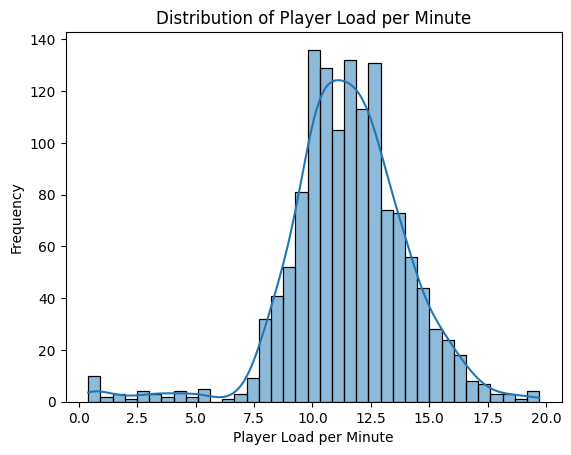

In [48]:
sns.histplot(data['Player Load Per Minute'], kde=True)
plt.title("Distribution of Player Load per Minute")
plt.xlabel("Player Load per Minute")
plt.ylabel("Frequency")
plt.show()

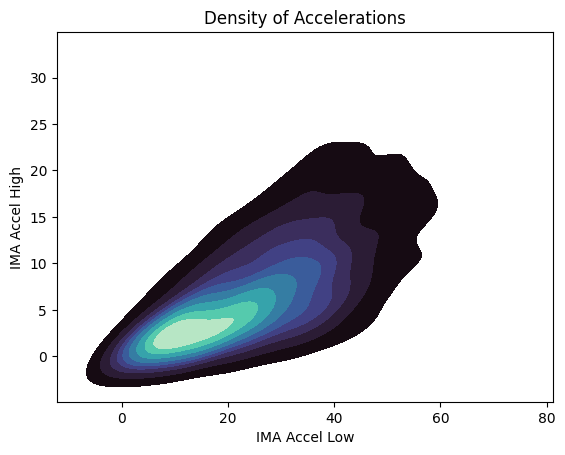

In [51]:
sns.kdeplot(x='IMA Accel Low', y='IMA Accel High', data=data, fill=True, cmap='mako')
plt.title("Density of Accelerations")
plt.show()

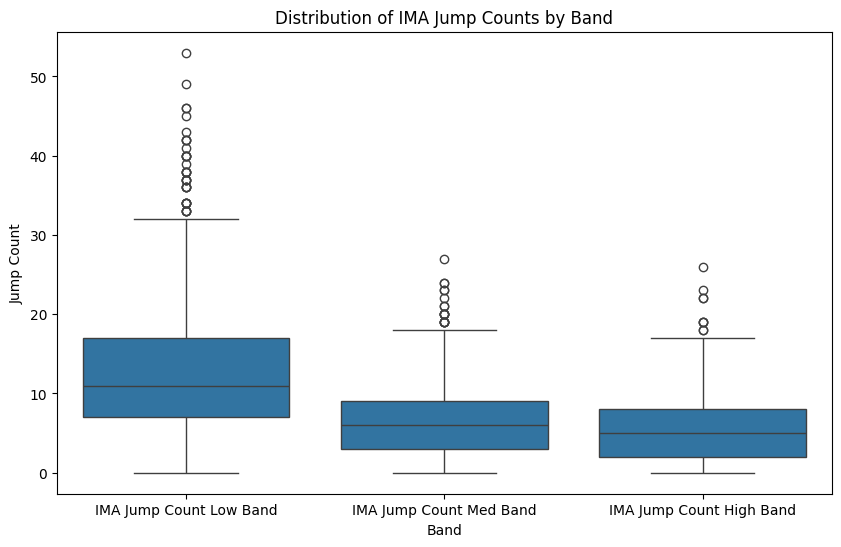

In [50]:
|plt.figure(figsize=(10, 6))
data_melted = data.melt(value_vars=['IMA Jump Count Low Band', 'IMA Jump Count Med Band', 'IMA Jump Count High Band'], var_name='Band', value_name='Jump Count')
sns.boxplot(x='Band', y='Jump Count', data=data_melted)
plt.title("Distribution of IMA Jump Counts by Band")
plt.xticks()
plt.show()

## Examine Correlations (If Relevant)

- Interpret Findings: What variables appear related?

In [69]:
data['About'].unique()

array(['Athlete H', 'Athlete J', 'Athlete B', 'Athlete D', 'Athlete G',
       'Athlete E', 'Athlete F', 'Athlete C', 'Athlete A', 'Athlete I',
       'Ben Vander Plas', 'Athlete Q', 'Athlete M', 'Athlete P',
       'Athlete O', 'Athlete N', 'Athlete R', 'Athlete L', 'Athlete S',
       'Athlete T', 'Athlete K'], dtype=object)

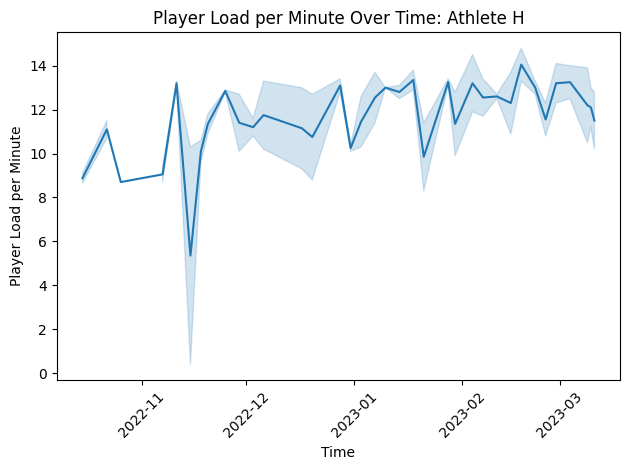

In [70]:
player_name = "Athlete H"
df_player = data[data['About'] == player_name]

df_player = df_player.sort_values('Date')

sns.lineplot(x='Date', y='Player Load Per Minute', data=df_player)
plt.title(f"Player Load per Minute Over Time: {player_name}")
plt.xlabel("Time")
plt.ylabel("Player Load per Minute")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

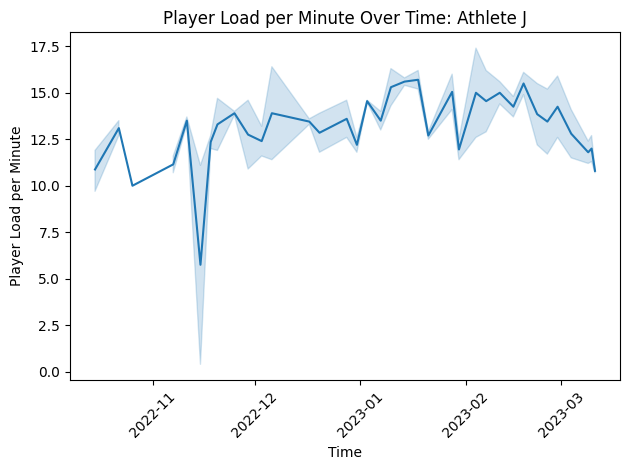

In [71]:
player_name = "Athlete J"
df_player = data[data['About'] == player_name]

df_player = df_player.sort_values('Date')

sns.lineplot(x='Date', y='Player Load Per Minute', data=df_player)
plt.title(f"Player Load per Minute Over Time: {player_name}")
plt.xlabel("Time")
plt.ylabel("Player Load per Minute")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

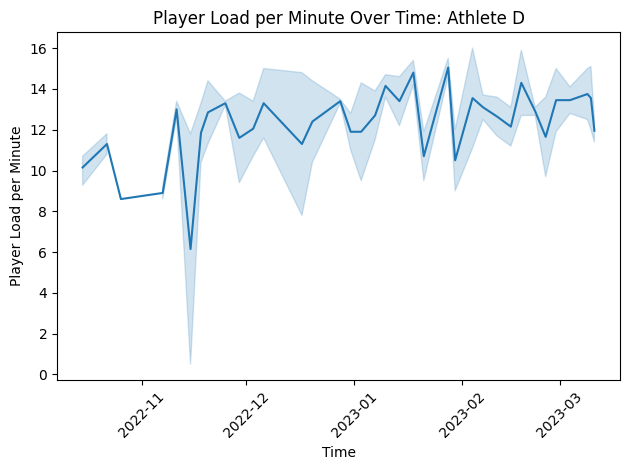

In [72]:
player_name = "Athlete D"
df_player = data[data['About'] == player_name]

df_player = df_player.sort_values('Date')

sns.lineplot(x='Date', y='Player Load Per Minute', data=df_player)
plt.title(f"Player Load per Minute Over Time: {player_name}")
plt.xlabel("Time")
plt.ylabel("Player Load per Minute")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Just from these 3 athletes we see a general upward trend in player load per minute over the course of the season. While this could merely indicate an increased demand during late-season play, we could also infer that players have are in better physical condition which allows them to exert more effort.

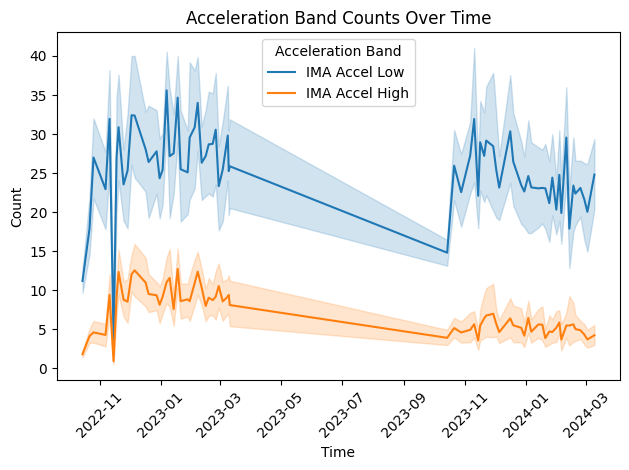

In [74]:
df_melted = data.melt(id_vars='Date', value_vars=['IMA Accel Low', 'IMA Accel High'], var_name='Acceleration Band', value_name='Count')

# Plot
sns.lineplot(data=df_melted, x='Date', y='Count', hue='Acceleration Band')
plt.title("Acceleration Band Counts Over Time")
plt.xlabel("Time")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


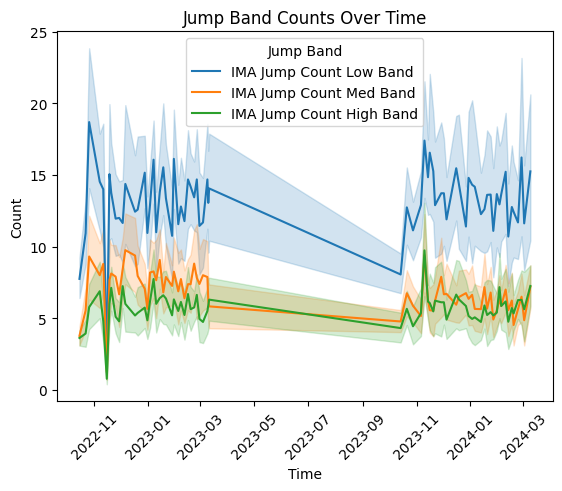

In [78]:
df_melted = data.melt(id_vars='Date', value_vars=['IMA Jump Count Low Band', 'IMA Jump Count Med Band', 'IMA Jump Count High Band'], var_name='Jump Band', value_name='Count')

# Plot
sns.lineplot(data=df_melted, x='Date', y='Count', hue='Jump Band')
plt.title("Jump Band Counts Over Time")
plt.xlabel("Time")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


Since our primary concern is the change in these variables over time, this will be our primary relationship in our plotting.

## Explore Relationship (If Relevant)

- Dig into potential causal or descriptive relationships

- Use visualizations and statistical summaries